VT
2013-01-01-2023-01-01
final_profit_rate: 41.84%
final_profit_rate_with_dividend: 41.84%


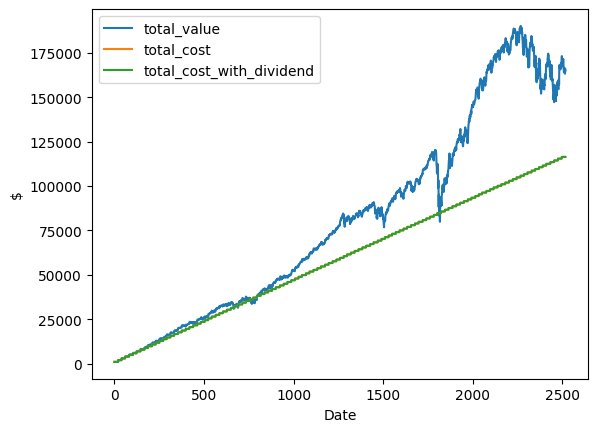

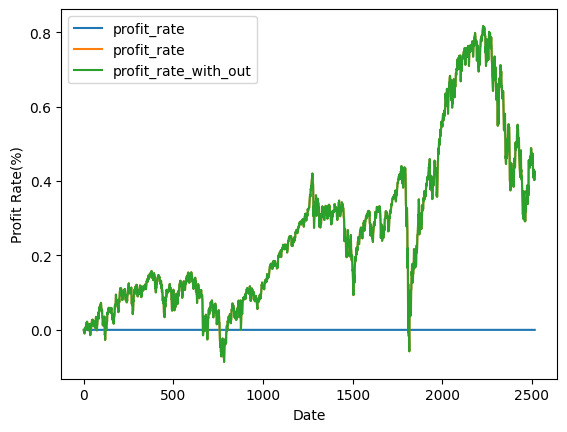

In [1]:
from app.main.Main import Main

app = Main()
app.code = "VT" # 股票代碼
app.start_date = "2013-01-01" # 起始日期
app.end_date = "2023-01-01" # 結束日期
app.investment_amount = 1000
app.purchase_day = 1
app.is_fund = False
app.using_taiwan_stock_crawl = True
app.using_taiwan_etf_crawl = False

app.launch()

0050.TW
2013-01-01-2023-01-01
final_profit_rate: 40.84%
final_profit_rate_with_dividend: 81.8%


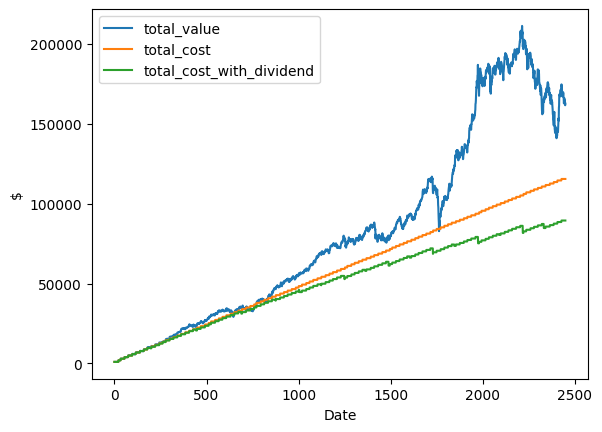

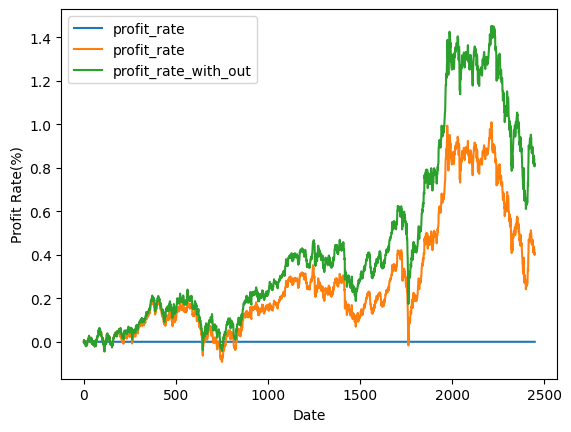

In [2]:
from app.main.Main import Main

app = Main()
app.code = "0050.TW" # 股票代碼
app.start_date = "2013-01-01" # 起始日期
app.end_date = "2023-01-01" # 結束日期
app.investment_amount = 1000
app.purchase_day = 1
app.is_fund = False
app.using_taiwan_stock_crawl = True
app.using_taiwan_etf_crawl = False

app.launch()

0056.TW
2013-01-01-2023-01-01
final_profit_rate: -1.73%
final_profit_rate_with_dividend: 49.39%


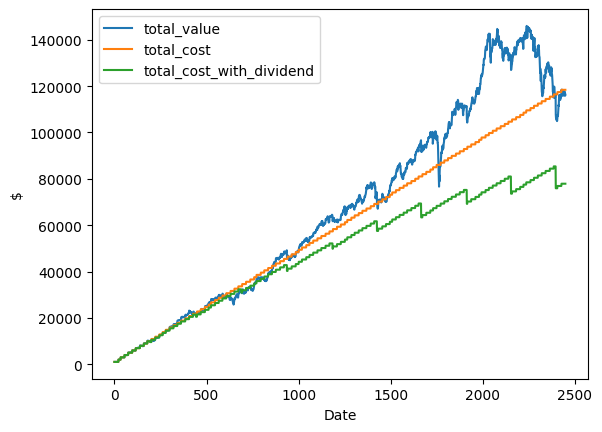

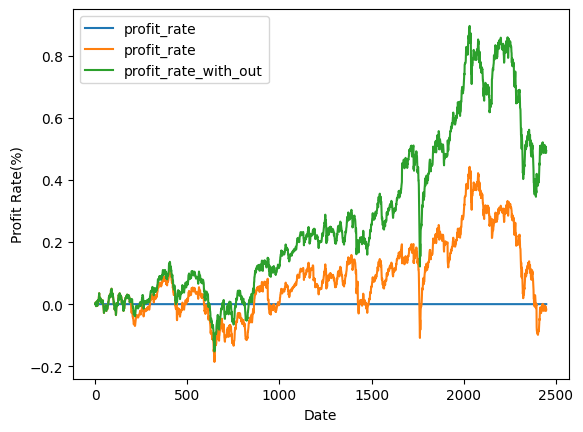

In [3]:
from app.main.Main import Main

app = Main()
app.code = "0056.TW" # 股票代碼
app.start_date = "2013-01-01" # 起始日期
app.end_date = "2023-01-01" # 結束日期
app.investment_amount = 1000
app.purchase_day = 1
app.is_fund = False
app.using_taiwan_stock_crawl = True
app.using_taiwan_etf_crawl = False

app.launch()

2884.TW
2013-01-01-2023-01-01
final_profit_rate: 100.9%
final_profit_rate_with_dividend: 229.2%


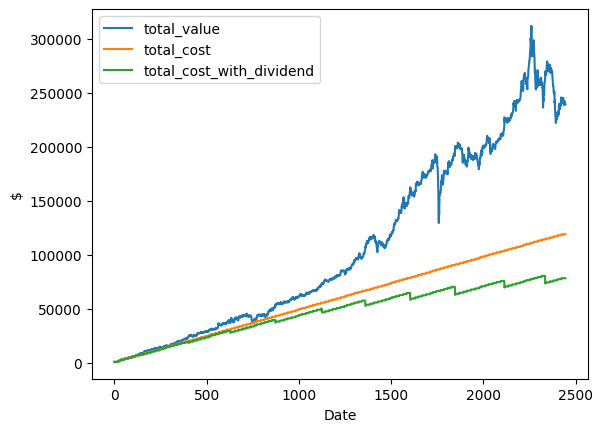

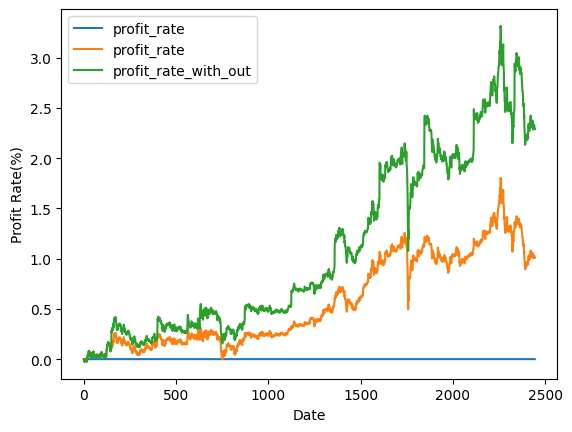

In [4]:
from app.main.Main import Main

app = Main()
app.code = "2884.TW" #玉山金
app.start_date = "2013-01-01" # 起始日期
app.end_date = "2023-01-01" # 結束日期
app.investment_amount = 1000
app.purchase_day = 1
app.is_fund = False
app.using_taiwan_stock_crawl = True
app.using_taiwan_etf_crawl = False

app.launch()

5880.TW
2013-01-01-2023-01-01
final_profit_rate: 121.84%
final_profit_rate_with_dividend: 291.19%


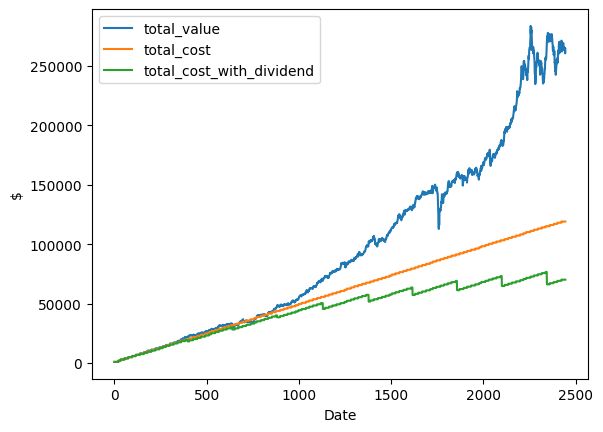

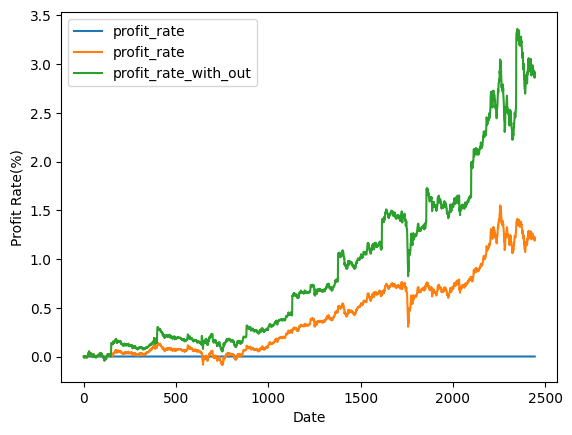

In [5]:
from app.main.Main import Main

app = Main()
app.code = "5880.TW" # 合庫金
app.start_date = "2013-01-01" # 起始日期
app.end_date = "2023-01-01" # 結束日期
app.investment_amount = 1000
app.purchase_day = 1
app.is_fund = False
app.using_taiwan_stock_crawl = True
app.using_taiwan_etf_crawl = False

app.launch()

9941.TW
2013-01-01-2023-01-01
final_profit_rate: 230.02%
final_profit_rate_with_dividend: 1400.41%


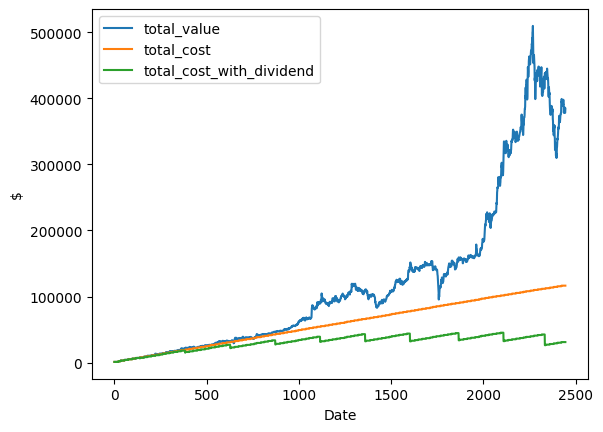

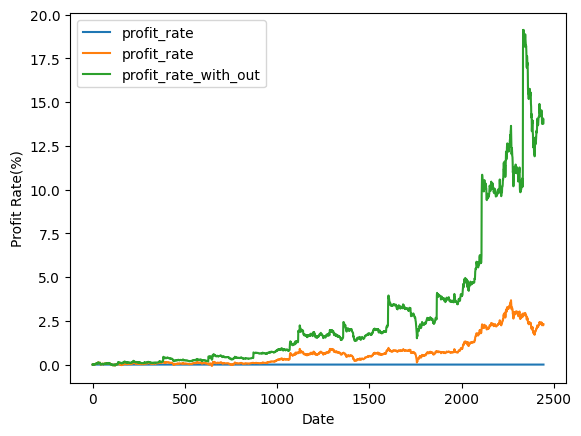

In [6]:
from app.main.Main import Main

app = Main()
app.code = "9941.TW" # 裕融
app.start_date = "2013-01-01" # 起始日期
app.end_date = "2023-01-01" # 結束日期
app.investment_amount = 1000
app.purchase_day = 1
app.is_fund = False
app.using_taiwan_stock_crawl = True
app.using_taiwan_etf_crawl = False

app.launch()

2882.TW
2013-01-01-2023-01-01
final_profit_rate: 16.29%
final_profit_rate_with_dividend: 98.16%


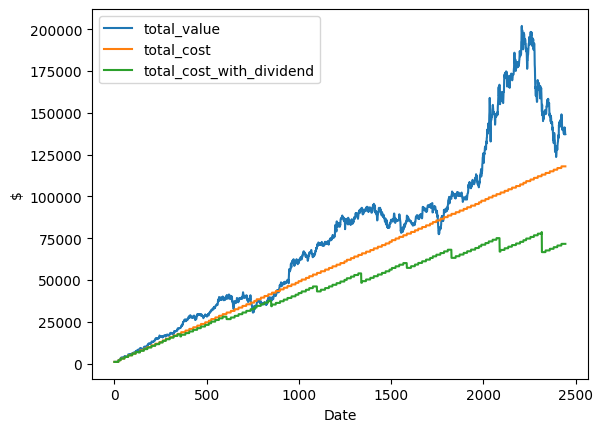

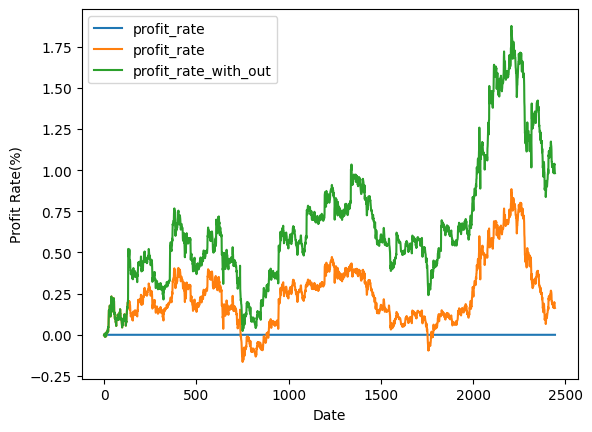

In [7]:
from app.main.Main import Main

app = Main()
app.code = "2882.TW" # 國泰金
app.start_date = "2013-01-01" # 起始日期
app.end_date = "2023-01-01" # 結束日期
app.investment_amount = 1000
app.purchase_day = 1
app.is_fund = False
app.using_taiwan_stock_crawl = True
app.using_taiwan_etf_crawl = False

app.launch()

crawl url: https://goodinfo.tw/tw/StockDividendSchedule.asp?STOCK_ID=2330
2330.TW
2013-01-01-2023-01-01
final_profit_rate: 195.0%
final_profit_rate_with_dividend: 390.85%


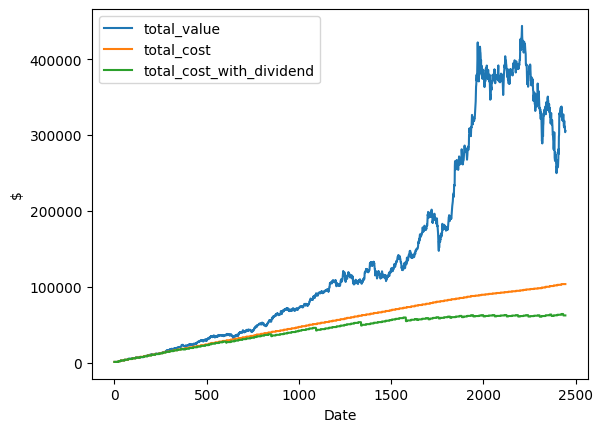

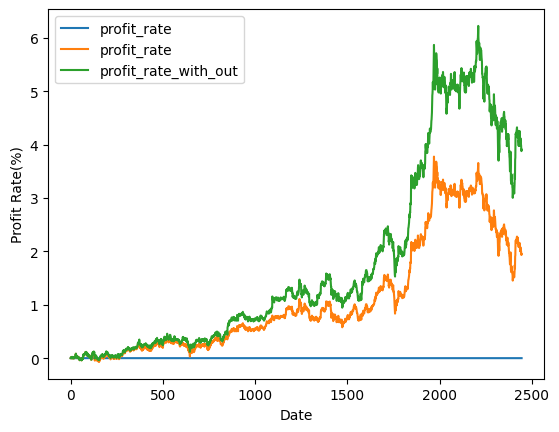

In [8]:
from app.main.Main import Main

app = Main()
app.code = "2330.TW" # 台積電
app.start_date = "2013-01-01" # 起始日期
app.end_date = "2023-01-01" # 結束日期
app.investment_amount = 1000
app.purchase_day = 1
app.is_fund = False
app.using_taiwan_stock_crawl = True
app.using_taiwan_etf_crawl = False

app.launch()